In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import quandl
from pathlib import Path
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import date
import numpy as np
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression, LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import utils
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, cross_val_score
from prophet import Prophet

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

yf.pdr_override()

In [2]:
#setting today's date
today = date.today()

In [3]:
# getting the data

# 10 Year note
us_treasury = pd.read_csv(r"csvs/10 yr treasury csv.csv",infer_datetime_format=True,parse_dates=True).set_index("Date")
#us_treasury = us_treasury['10 YR'].to_frame()
us_treasury

# gold prices
gold = pd.read_csv(r"csvs/gold prices csv.csv",infer_datetime_format=True,parse_dates=True).set_index("Date")
#gold = gold['USD (AM)']
#gold = gold.to_frame()
gold

# emerging markets high yield corporate bond index yield
emerging_markets_high_yield_corporate_bond_index_yield = pd.read_csv(r"csvs/Emerging Markets HYCBIY Value csv.csv",infer_datetime_format=True,parse_dates=True).set_index("DATE")
emerging_markets_high_yield_corporate_bond_index_yield

# s&p 500 inflation adjusted
sp_500_inflation_adjusted = pd.read_csv(r"csvs/Emerging Markets HYCBIY Value csv.csv",infer_datetime_format=True,parse_dates=True).set_index("DATE")
sp_500_inflation_adjusted

# personal consumption expenditures
personal_consumption_expenditures = pd.read_csv("csvs/personal consumption expenditures csv.csv",infer_datetime_format=True,parse_dates=True).set_index("Date")

In [4]:
# Dow Jones 
dji = pd.read_csv(r"csvs/Download Data - INDEX_US_DOW JONES GLOBAL_DJIA_3.csv",infer_datetime_format=True,parse_dates=True, thousands=",").set_index("Date")
# setting dow to be our test
y = dji["Close"].iloc[::-1]
y = y.apply(lambda x: float(x))
y = y.to_frame()
y

,Close
Date,
7/1/80,872.27
8/1/80,931.48
9/2/80,940.78
10/1/80,939.42
11/3/80,937.20
...,...
3/1/21,31535.51
4/1/21,33153.21
5/3/21,34113.23


In [5]:
#personal_consumption_expenditures.rename(columns={"Value":"PCE Value"},inplace=True)
#gold.rename(columns={"Value":"Gold Value"},inplace=True)
#sp_500_inflation_adjusted.rename(columns={'Value':'SPY Value'},inplace=True)
#emerging_markets_high_yield_corporate_bond_index_yield.rename(columns={'BAMLEMHBHYCRPIEY':'Emerging Markets HYCBIY Value'},inplace=True)

In [6]:
# aggregating data into dataframe
df = pd.concat([us_treasury,gold,emerging_markets_high_yield_corporate_bond_index_yield,
                  sp_500_inflation_adjusted,personal_consumption_expenditures,y],axis = 'columns', join = 'inner')
df = df.pct_change()
df.dropna(inplace = True)


In [7]:
df

,10 YR,USD (AM),Emerging Markets HYCBIY Value,Emerging Markets HYCBIY Value,PCE Value,Close
3/1/99,0.136842,-0.000174,-0.028840,-0.028840,0.005097,-0.002238
4/1/99,-0.024074,-0.022818,-0.076824,-0.076824,0.010321,0.054450
6/1/99,0.096774,-0.053476,-0.027273,-0.027273,0.009328,0.077676
7/1/99,0.012111,-0.009416,-0.027318,-0.027318,0.004397,0.044370
9/1/99,0.023932,-0.028707,0.008869,0.008869,0.015490,-0.011615
...,...,...,...,...,...,...
10/1/20,0.000000,-0.046480,0.076807,0.076807,0.003045,-0.028931
12/1/20,0.352941,-0.052412,-0.153846,-0.153846,-0.012032,0.072151
2/1/21,0.184783,0.034295,-0.056198,-0.056198,0.022344,0.013009
3/1/21,0.330275,-0.059667,0.003503,0.003503,0.050176,0.043811


In [8]:
X = df.drop(columns='Close')
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=42,shuffle=False)

In [9]:
y_test

12/1/15    0.099333
2/1/16    -0.080453
3/1/16     0.025284
4/1/16     0.055005
6/1/16    -0.000173
7/1/16     0.008977
8/1/16     0.025357
9/1/16     0.000804
11/1/16   -0.020750
12/1/16    0.064025
2/1/17     0.036422
3/1/17     0.061566
6/1/17     0.001356
8/1/17     0.038769
9/1/17     0.001076
11/1/17    0.065830
12/1/17    0.033991
2/1/18     0.080685
3/1/18    -0.060249
5/1/18    -0.020721
6/1/18     0.022248
8/1/18     0.028358
10/1/18    0.052001
11/1/18   -0.047670
2/1/19    -0.012484
3/1/19     0.038399
4/1/19     0.008918
5/1/19     0.006540
7/1/19     0.010870
8/1/19    -0.005016
10/1/19   -0.000390
11/1/19    0.029139
4/1/20    -0.234167
5/1/20     0.132747
6/1/20     0.073822
7/1/20     0.010204
9/1/20     0.113103
10/1/20   -0.028931
12/1/20    0.072151
2/1/21     0.013009
3/1/21     0.043811
4/1/21     0.051298
Name: Close, dtype: float64

In [10]:

type(y_test.index)

pandas.core.indexes.base.Index

In [11]:
scaler = StandardScaler()

# Fitting the training data to the model
X_scaler = scaler.fit(X_train)

# Scaling the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [12]:
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
y_test_encoded = lab_enc.fit_transform(y_test)
y_train_encoded

array([ 48, 103, 120,  92,  40,  10,  85,  83,  54,   7, 100,  46, 112,
        23,  15, 111,  14,  89,  56,  18,   1,  96, 115,  94,  24,   4,
         9,   8, 118,  13,  95, 114,  59,  84,  93, 121,  26,  34,  60,
        35,  52,  38, 101,  47,  75,  19,  63,  31,  81,  37,  43,  97,
        53,  57,  67,  39,  80,  98,  62,  86,  22, 119,  87,  32, 102,
        20,  11,  42,  79,   2,  44,  17,   0,  16, 108, 113,  30, 122,
        70, 123,  28,  71,  99,   6,  25, 105, 104,  77,  58, 116,  50,
        76,  41,  73,  21,  12,  64,  82, 107,  69,  72,   5, 117,  88,
        33, 110,  55,  90,  66,  91,  27,  78, 109,  51,  74,  29,  68,
       106,  45,  65,  49,  36,   3,  61], dtype=int64)

Coefficients: 
 [ 0.01541613 -0.00690438 -0.01259625 -0.01259625  0.00166324]
Mean squared error: 0.0013538408
Coefficient of determination: 0.60


C:\Users\Sebs1\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


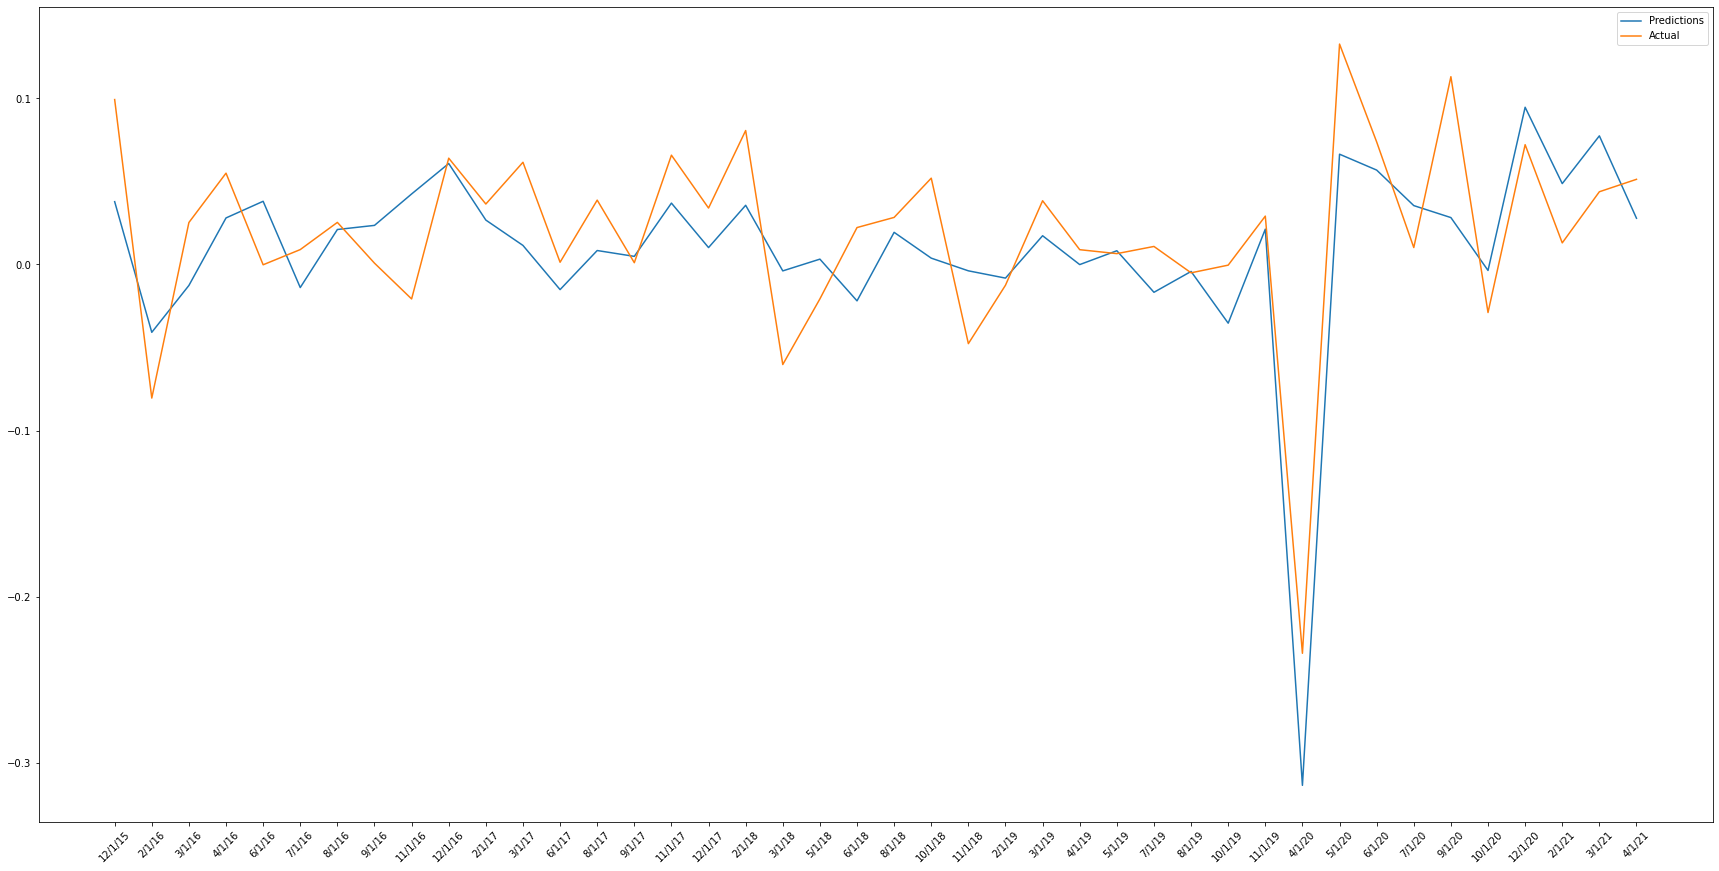

In [13]:
# Logistic Regression Model
regr = LinearRegression()
regr.fit(X_train_scaled, y_train)

predictions = regr.predict(X_test_scaled)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, predictions))
test = pd.DataFrame({"Prediction": list(predictions), "Actual": list(y_test.values)})
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(15)
line1 = ax.plot(predictions, label="Predictions")
line2 = plt.plot(y_test, label = 'Actual')
#plt.plot(test)
plt.xticks(rotation = 45)
plt.legend()
fig.show()

In [14]:

# Fitting the decision tree
model = tree.DecisionTreeRegressor()
model = model.fit(X_train_scaled, y_train)

# Making predictions
predictions = model.predict(X_test_scaled)

In [15]:
predictions = model.predict(X_test)
# The coefficients
print('Coefficients: \n', model.coef_)
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, predictions))
test = pd.DataFrame({"Prediction": list(predictions), "Actual": list(y_test.values)})
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(15)
line1 = ax.plot(predictions, label="Predictions")
line2 = plt.plot(y_test, label = 'Actual')
#plt.plot(test)
plt.xticks(rotation = 45)
plt.legend()
fig.show()

AttributeError: 'DecisionTreeRegressor' object has no attribute 'coef_'

In [ ]:
m = Prophet()
m.fit(y)
future = m.make_future_dataframe(periods=365)
future.tail()

In [ ]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
cat.fit(X,y)

Feature: 0, Score: 0.01542
Feature: 1, Score: -0.00690
Feature: 2, Score: -0.01260
Feature: 3, Score: -0.01260
Feature: 4, Score: 0.00166


array([ 0.01541613, -0.00690438, -0.01259625, -0.01259625,  0.00166324])

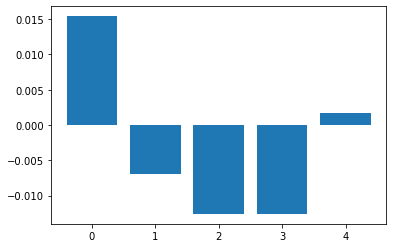

In [17]:
importance = regr.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
f = plt.bar([x for x in range(len(importance))], importance)
importance